# Retrieving netCDF data from the CDS and plotting it with Metview

<img src="https://ads.atmosphere.copernicus.eu/themes/custom/baby_blue/logo.svg" width=140> 
Demonstrates how to retrieve NetCDF data from the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/) (ADS) and visualise it with Cartopy.

Let's retrieve CAMS reanalysis PM2.5 global field and plot it.

In [3]:
import cdsapi
import urllib3
urllib3.disable_warnings()

URL = "https://ads.atmosphere.copernicus.eu/api/v2"
KEY = "3512:52600066-3b0b-4213-bb5d-2d9b686b7fce"

c = cdsapi.Client(url=URL, key=KEY)

DATE = "2020-11-09"
hours = [str(h) for h in range(97)]
models = [ 'chimere', 'dehm', 'emep', 'ensemble', 'euradim', 'gemaq', 'lotos', 'match', 'mocage', 'silam']
for model in models:
    
    c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': model,
        'date': DATE,
        'format': 'netcdf',
        'variable': 'nitrogen_dioxide',
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': hours,
        'level': '0',
    },
    f'/mnt/e/tmp/air_quality_{model}_{DATE}.nc')


/home/miha/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2020-11-09 15:05:14,172 INFO Welcome to the CDS
2020-11-09 15:05:14,173 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
/home/miha/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2020-11-09 15:05:14,220 INFO Request is queued
/home/miha/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified

Reads the netCDF data from disk.

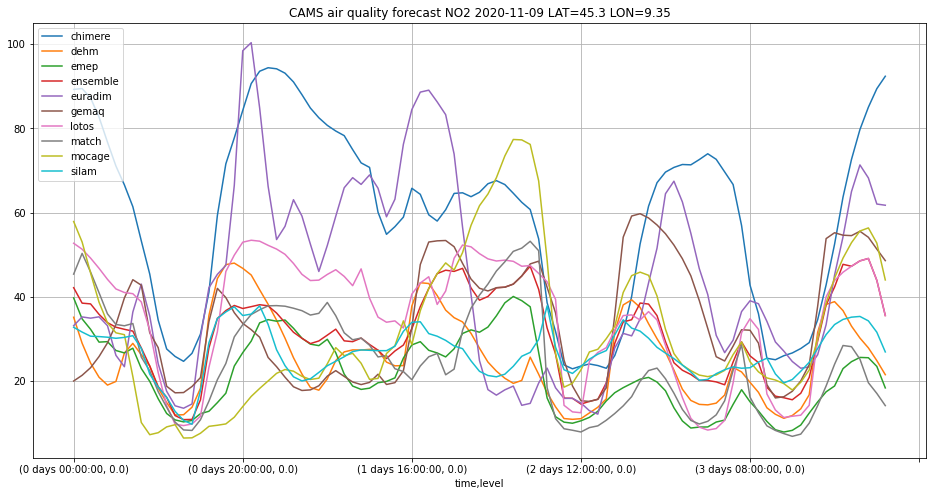

In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
param = "NO2"
lat = 45.3
lon = 9.35

import xarray as xr

fig = plt.figure(figsize=(16,8))
ax = fig.subplots()

for model in models:
    dset = xr.open_dataset(f'/mnt/e/tmp/air_quality_{model}_{DATE}.nc')
# print(dset)
    dd = dset["no2_conc"].interp(latitude=45.3, longitude=9.35).to_dataframe()
    dd.no2_conc.plot(ax=ax, label=model)

plt.grid()
plt.legend()
plt.title(f"CAMS air quality forecast {param} {DATE} LAT={lat} LON={lon}")
plt.savefig(f"cams_aq_fc_{DATE}.png")

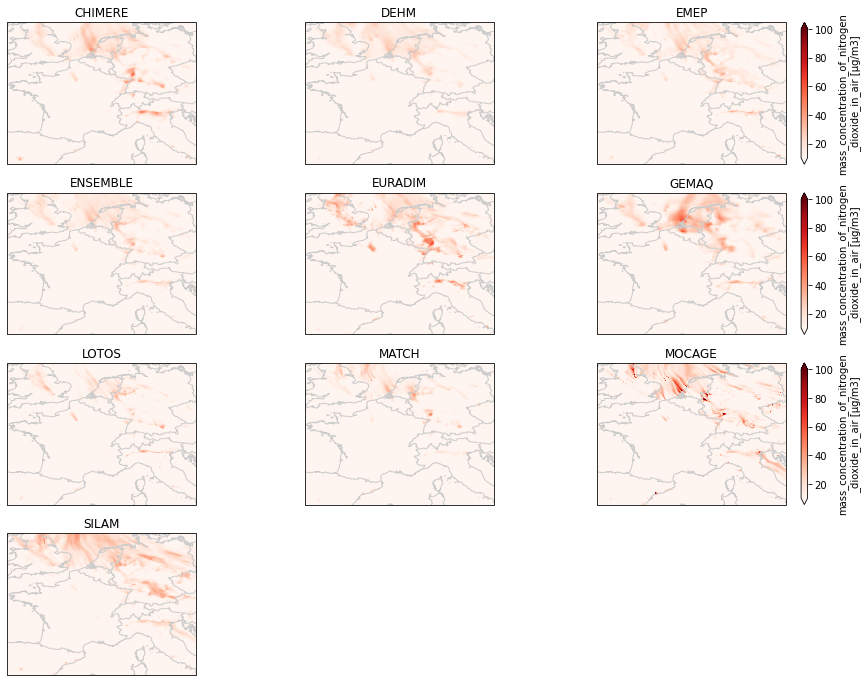

In [82]:
BORDER_COLOUR = "#cccccc"
NCOLS = 3
NROWS = len(models) // NCOLS + 1

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(16,12), subplot_kw={'projection': ccrs.PlateCarree()})

for ii, model in enumerate(models):
    dset = xr.open_dataset(f'/mnt/e/tmp/air_quality_{model}_{DATE}.nc')
    dset = dset.assign_coords(longitude=(((dset.longitude + 180) % 360) - 180)).sortby('longitude')    

    iy = ii // NCOLS
    ix = ii % NCOLS 
    show_cbar = NCOLS - ix == 1
    p = dset["no2_conc"][13][0].plot.pcolormesh(ax=axes[iy, ix], vmin=10, vmax=100., 
                                                add_colorbar=show_cbar, extend='both', cmap='Reds', 
                                                transform=ccrs.PlateCarree())
    axes[iy, ix].set_title(model.upper())
    axes[iy, ix].xaxis.set_label_text("")
    axes[iy, ix].yaxis.set_label_text("")
    axes[iy, ix].set_extent([-5, 15, 40, 55])
    axes[iy, ix].add_feature(cartopy.feature.BORDERS, linestyle='-', color=BORDER_COLOUR, alpha=1)
    axes[iy, ix].coastlines(color=BORDER_COLOUR)
    
# let's remove axes on the empty subplots
for iix in range(ix + 1, NROWS - 1):
    axes[iy, iix].axis('off')

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=.0, hspace=0.2)